In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
raw_data = pd.read_csv('../data/transformed_raw.csv', parse_dates=['lifetime_start','lifetime_end'])

In [3]:
def getPercentNull(df, columnName):
    return df[columnName].isnull().sum() / (df[columnName].notnull().sum() + df[columnName].isnull().sum())

In [4]:
from sklearn.preprocessing import LabelEncoder

def encode(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    
    # classes = list(le.classes_)
    # print(column + ":")
    # for key in range(len(classes)):
        # print('[' + str(key) + '] ' + str(classes[key]))
    # print('')
    return df

In [5]:
def generate_candidate_dataset(data_in, COLUMN_DROP_THRESHOLD, COLUMN_IMPUTE_THRESHOLD):
    this_data = data_in.copy()
    for column in this_data:
        this_percent_null = getPercentNull(this_data, column)
    
        if (this_percent_null >= COLUMN_DROP_THRESHOLD):
            del this_data[column]
        elif (this_percent_null >= COLUMN_IMPUTE_THRESHOLD):
            this_data.dropna(subset=[column], axis=0, inplace=True)
        else:
            # ADD IMPUTE FUNCTION HERE
            pass

    return this_data

In [6]:
raw_data.head()

,roduid,UWI,lifetime_start,lifetime_end,FAILURETYPE,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,...,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od,lifetime
0,GB42ZGOU04727141361583,005-64-9456,2019-07-16,2020-02-13,Tubing,0.0,80.0,65.0,165.878957,174.734193,...,174.27,174.27,Miller LLC,NaN,NaN,1167.96,8893.9,2.00,4.5,212
1,GB87DDTZ53468840486615,006-40-5581,2006-02-07,2006-09-22,Sucker Rod Pump,0.0,75.0,60.0,144.000000,NaN,...,NaN,NaN,Miller LLC,NaN,NaN,NaN,9085.2,1.75,NaN,227
2,GB30HELP48302296915492,006-40-5581,2006-09-23,2009-06-25,Sucker Rod Pump,0.0,75.0,60.0,144.000000,NaN,...,NaN,NaN,Miller LLC,NaN,NaN,NaN,9085.2,1.50,NaN,1006
3,GB73EZQN38331541380411,006-57-3389,2017-10-18,2018-05-15,Tubing,0.0,70.0,65.0,165.761084,165.840171,...,NaN,NaN,Miller LLC,NaN,NaN,NaN,11505.2,1.25,NaN,209
4,GB71WFOX64096101197026,006-57-3389,2018-05-18,2018-07-18,Sucker Rod Pump,0.0,70.0,65.0,168.259995,156.448266,...,NaN,NaN,Miller LLC,NaN,NaN,NaN,11387.1,1.25,NaN,61


In [7]:
categorical_columns = ['bha_configuration',
                      'wellbore_category',
                       'packer_vs_tac',
                       'rod_sinker_type',
                       'manual_scale',
                       'rod_make',
                       'rod_apigrade',
                       'DESANDDEGAS_TYP',
                       'rod_has_guides',
                       'FAILURETYPE'
                      ]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import metrics

In [9]:
def run_svc_iteration(df, COLUMN_DROP_THRESHOLD, COLUMN_IMPUTE_THRESHOLD):

    this_data = generate_candidate_dataset(df, COLUMN_DROP_THRESHOLD, COLUMN_IMPUTE_THRESHOLD)

    for column in this_data:
        if (column in categorical_columns):
            encode(this_data, column)

    features = list(this_data)
    features.remove('FAILURETYPE')
    features.remove('roduid')
    features.remove('UWI')
    features.remove('lifetime_start')
    features.remove('lifetime_end')

    X = np.array(this_data[features])
    y = np.array(this_data['FAILURETYPE'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg_svc = SVC(gamma='auto')
    reg_svc.fit(X_train, y_train)
    y_pred = reg_svc.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)

In [10]:
def run_knn_iteration(df, COLUMN_DROP_THRESHOLD, COLUMN_IMPUTE_THRESHOLD, K_VALUES):
    this_data = generate_candidate_dataset(df, COLUMN_DROP_THRESHOLD, COLUMN_IMPUTE_THRESHOLD)
    
    for column in this_data:
        if (column in categorical_columns):
            encode(this_data, column)
            
    features = list(this_data)
    features.remove('FAILURETYPE')
    features.remove('roduid')
    features.remove('UWI')
    features.remove('lifetime_start')
    features.remove('lifetime_end')

    X = np.array(this_data[features])
    y = np.array(this_data['FAILURETYPE'])

    knn = KNeighborsClassifier(n_neighbors=K_VALUES)
    this_score = cross_val_score(knn, X, y, cv=8, scoring='roc_auc_ovo')
    
    return this_score.mean()

Best accuracy is 0.6493506493506493 at 56.


<AxesSubplot:>

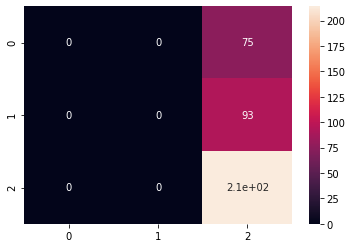

In [41]:
# MAIN PROGRAM FOR SVC ITERATION
max_result = 0

for this_column_drop_threshold in range(1, 100, 5):
    try:
        this_result = run_svc_iteration(raw_data, this_column_drop_threshold/100, 0)
    except:
        # print("Iteration with drop threshold " + str(this_column_drop_threshold) + " and k values " + str(this_k_values) + " failed.")
        continue
    if (this_result > max_result):
        max_result = this_result
        max_threshold = this_column_drop_threshold
        
print("Best accuracy is " + str(max_result) + " at " + str(max_threshold) + ".")

# Print Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

this_data = generate_candidate_dataset(raw_data, max_threshold/100, 0)

for column in this_data:
    if (column in categorical_columns):
        encode(this_data, column)
            
features = list(this_data)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
features.remove('lifetime_start')
features.remove('lifetime_end')

X = np.array(this_data[features])
y = np.array(this_data['FAILURETYPE'])

svc = SVC(gamma='auto')
y_pred = cross_val_predict(svc, X, y, cv=5)

conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True)

<AxesSubplot:>

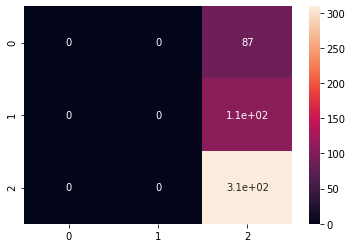

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

this_data = generate_candidate_dataset(raw_data, 50/100, 0)

for column in this_data:
    if (column in categorical_columns):
        encode(this_data, column)
            
features = list(this_data)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
features.remove('lifetime_start')
features.remove('lifetime_end')

X = np.array(this_data[features])
y = np.array(this_data['FAILURETYPE'])

svc = SVC(gamma='auto')
y_pred = cross_val_predict(svc, X, y, cv=5)

conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True)

Best accuracy is 0.6451077837850943 at 6 and k=48.


<AxesSubplot:>

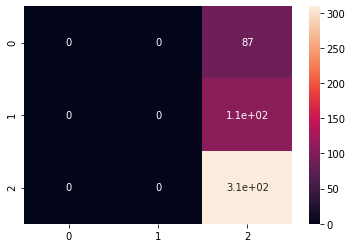

In [42]:
# MAIN PROGRAM FOR KNN ITERATION
max_result = 0

for this_column_drop_threshold in range(1, 100, 5):
    for this_k_values in range(1, 100, 1):
        try:
            this_result = run_knn_iteration(raw_data, this_column_drop_threshold/100, 0, this_k_values)
        except:
           # print("Iteration with drop threshold " + str(this_column_drop_threshold) + " and k values " + str(this_k_values) + " failed.")
           continue
        if (this_result > max_result):
            max_result = this_result
            max_threshold = this_column_drop_threshold
            max_k_values = this_k_values
        
print("Best accuracy is " + str(max_result) + " at " + str(max_threshold) + " and k=" + str(max_k_values) + ".")

# Print Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

this_data = generate_candidate_dataset(raw_data, .45, 0)

for column in this_data:
    if (column in categorical_columns):
        encode(this_data, column)
            
features = list(this_data)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
features.remove('lifetime_start')
features.remove('lifetime_end')

X = np.array(this_data[features])
y = np.array(this_data['FAILURETYPE'])

knn = KNeighborsClassifier(n_neighbors=max_k_values)
y_pred = cross_val_predict(knn, X, y, cv=5)

conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True)

In [49]:
this_data = generate_candidate_dataset(raw_data, .25, 0)
this_data['FAILURETYPE'].value_counts()/this_data['FAILURETYPE'].count()

Tubing             0.559778
Sucker Rod Pump    0.305622
Rods               0.134600
Name: FAILURETYPE, dtype: float64